In [ ]:
import os 
import zipfile 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import cv2
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import shutil
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ishfaqrahman","key":"a7a6b0c6e488a8f3af994f0eb7f8cc11"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s 'surface crack detection'

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection

surface-crack-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile 
local_dir='/content/surface-crack-detection.zip'
zip_ref=zipfile.ZipFile(local_dir,'r')
zip_ref.extractall('/surface')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/surface-crack-detection.zip' mode='r'>>

In [ ]:
import os
for dirname, _, filenames in os.walk('/surface'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Streaming output truncated to the last 5000 lines.
/surface/Negative/17116.jpg
/surface/Negative/15846.jpg
/surface/Negative/14132.jpg
/surface/Negative/12921.jpg
/surface/Negative/07541.jpg
/surface/Negative/14523.jpg
/surface/Negative/17354.jpg
/surface/Negative/11307.jpg
/surface/Negative/16886.jpg
/surface/Negative/05686.jpg
/surface/Negative/01625.jpg
/surface/Negative/14740.jpg
/surface/Negative/07339.jpg
/surface/Negative/01784.jpg
/surface/Negative/12826.jpg
/surface/Negative/03495.jpg
/surface/Negative/18458.jpg
/surface/Negative/13733.jpg
/surface/Negative/19088.jpg
/surface/Negative/16286.jpg
/surface/Negative/13254.jpg
/surface/Negative/15368.jpg
/surface/Negative/11849.jpg
/surface/Negative/19539.jpg
/surface/Negative/14556.jpg
/surface/Negative/12099.jpg
/surface/Negative/05775.jpg
/surface/Negative/15498.jpg
/surface/Negative/00807.jpg
/surface/Negative/13184.jpg
/surface/Negative/16187.jpg
/surface/Negative/03041.jpg
/surface/Negative/18362.jpg
/surface/Negative/06261.j

In [ ]:
Root = '/surface/'
TRAIN_PATH = 'train'
os.mkdir(TRAIN_PATH)

In [ ]:
def processImages(folder_name):
  src = Root + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)  

In [ ]:
processImages('Negative')
print('N Done')
processImages('Positive')
print('P Done')

N Done
P Done


In [ ]:
lr = 0.01
epochs = 2
batch_size = 20
input_size, output_size = 28 * 28, 2
hidden_size = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print(datasets)

Using cuda device
<module 'torchvision.datasets' from '/usr/local/lib/python3.7/dist-packages/torchvision/datasets/__init__.py'>


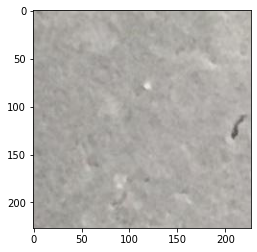

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('/surface/Negative/00001.jpg'))

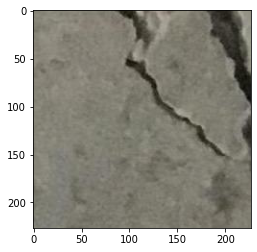

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('/surface/Positive/00088.jpg'))

In [ ]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])

dataset = datasets.ImageFolder(root='/surface', transform=transform)

train, test = torch.utils.data.random_split(dataset, [35000, 5000])


print(len(train))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)


print(len(test))
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)



35000
5000


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, hidden_size)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()


        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)

        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size, hidden_size, output_size)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6598400473594666. Accuracy: 66.24
Iteration: 1000. Loss: 0.6239925622940063. Accuracy: 67.38
Iteration: 1500. Loss: 0.6366360783576965. Accuracy: 72.16
Iteration: 2000. Loss: 0.6666051149368286. Accuracy: 69.28
Iteration: 2500. Loss: 0.48127874732017517. Accuracy: 69.16
Iteration: 3000. Loss: 0.47940173745155334. Accuracy: 76.18
Iteration: 3500. Loss: 0.36846691370010376. Accuracy: 79.14


[0.6598400473594666, 0.6239925622940063, 0.6366360783576965, 0.6666051149368286, 0.48127874732017517, 0.47940173745155334, 0.36846691370010376]


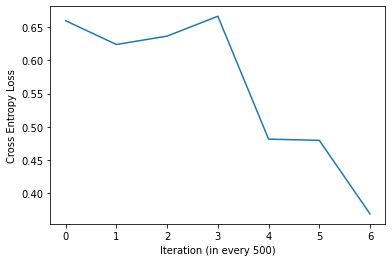

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Setting 2**

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

         # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size, hidden_size, output_size)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6892903447151184. Accuracy: 80.88
Iteration: 1000. Loss: 0.40812039375305176. Accuracy: 82.66
Iteration: 1500. Loss: 0.7490988969802856. Accuracy: 85.84
Iteration: 2000. Loss: 0.413710355758667. Accuracy: 85.76
Iteration: 2500. Loss: 0.32926660776138306. Accuracy: 84.62
Iteration: 3000. Loss: 0.5850354433059692. Accuracy: 85.02
Iteration: 3500. Loss: 0.6169499158859253. Accuracy: 85.94


[0.6892903447151184, 0.40812039375305176, 0.7490988969802856, 0.413710355758667, 0.32926660776138306, 0.5850354433059692, 0.6169499158859253]


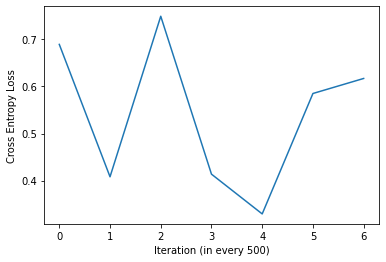

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Setting 3**

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.LeakyReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.LeakyReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

         # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size, hidden_size, output_size)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6979832053184509. Accuracy: 53.14
Iteration: 1000. Loss: 0.6898654699325562. Accuracy: 60.58
Iteration: 1500. Loss: 0.6370373964309692. Accuracy: 75.86
Iteration: 2000. Loss: 0.4752365052700043. Accuracy: 80.0
Iteration: 2500. Loss: 0.4811533987522125. Accuracy: 82.2
Iteration: 3000. Loss: 0.1410088837146759. Accuracy: 83.72
Iteration: 3500. Loss: 0.3667033314704895. Accuracy: 85.44


[0.6979832053184509, 0.6898654699325562, 0.6370373964309692, 0.4752365052700043, 0.4811533987522125, 0.1410088837146759, 0.3667033314704895]


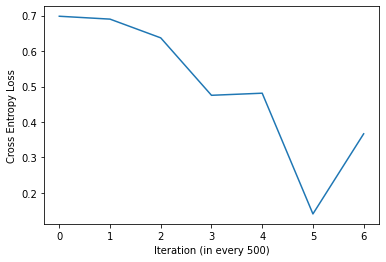

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Setting 4**

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_size,
                                num_classes=output_size)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 350 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 350. Loss: 0.2817063629627228. Accuracy: 78.8
Iteration: 700. Loss: 0.3414214849472046. Accuracy: 86.2
Iteration: 1050. Loss: 0.35522642731666565. Accuracy: 72.26
Iteration: 1400. Loss: 1.1360397338867188. Accuracy: 74.04
Iteration: 1750. Loss: 0.33669203519821167. Accuracy: 88.8
Iteration: 2100. Loss: 0.20802399516105652. Accuracy: 82.16
Iteration: 2450. Loss: 0.20888499915599823. Accuracy: 88.88
Iteration: 2800. Loss: 1.2038065195083618. Accuracy: 84.84
Iteration: 3150. Loss: 0.8509556651115417. Accuracy: 89.1
Iteration: 3500. Loss: 0.663032591342926. Accuracy: 87.26


[0.706222653388977, 0.2665514349937439, 0.34468939900398254, 0.44764256477355957, 0.4384554326534271, 0.1822623312473297, 0.4060443043708801]


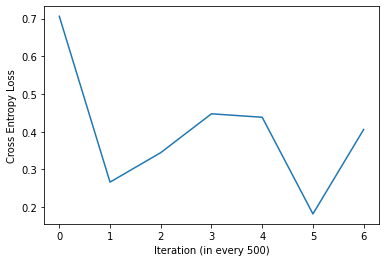

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

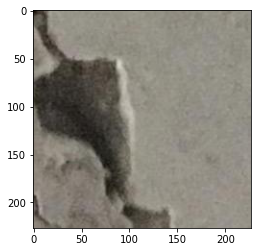

In [ ]:

img=Image.open('/content/train/00108.jpg')
plt.imshow(img)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
positive_dir = Path('/surface/Positive')
negative_dir = Path('/surface/Negative')

## Creating DataFrames

In [ ]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/surface/Positive/10481_1.jpg,POSITIVE
1,/surface/Positive/13284_1.jpg,POSITIVE
2,/surface/Positive/06920.jpg,POSITIVE
3,/surface/Negative/16424.jpg,NEGATIVE
4,/surface/Positive/06062.jpg,POSITIVE
...,...,...
39995,/surface/Positive/03130.jpg,POSITIVE
39996,/surface/Negative/10435.jpg,NEGATIVE
39997,/surface/Positive/06231.jpg,POSITIVE
39998,/surface/Positive/08951.jpg,POSITIVE


In [ ]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [ ]:
train_df.shape

(4200, 2)

In [ ]:
test_df.shape

(1800, 2)

# Loading Image Data

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


## Training

In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 [==============================] - 12s 54ms/step - loss: 0.6657 - accuracy: 0.6190 - val_loss: 0.6151 - val_accuracy: 0.7798
Epoch 2/100
105/105 [==============================] - 5s 51ms/step - loss: 0.5725 - accuracy: 0.7551 - val_loss: 0.5363 - val_accuracy: 0.7750
Epoch 3/100
105/105 [==============================] - 5s 51ms/step - loss: 0.4726 - accuracy: 0.8440 - val_loss: 0.4197 - val_accuracy: 0.8976
Epoch 4/100
105/105 [==============================] - 5s 51ms/step - loss: 0.3742 - accuracy: 0.8997 - val_loss: 0.3220 - val_accuracy: 0.9298
Epoch 5/100
105/105 [==============================] - 5s 51ms/step - loss: 0.2856 - accuracy: 0.9259 - val_loss: 0.2427 - val_accuracy: 0.9333
Epoch 6/100
105/105 [==============================] - 5s 51ms/step - loss: 0.2363 - accuracy: 0.9375 - val_loss: 0.2116 - val_accuracy: 0.9536
Epoch 7/100
105/105 [==============================] - 5s 51ms/step - loss: 0.1930 - accuracy: 0.9470 - val_loss: 0.1720 - val_accuracy

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [ ]:
fig = px.line(
    history.history,
    y=['accuracy', 'val_accuracy'],
    labels={'index': "Epoch", 'value': "Accuracy"},
    title="Training and Validation Accuracy Over Time")
fig.show()

# Results

In [ ]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.06472
Test Accuracy: 97.50%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



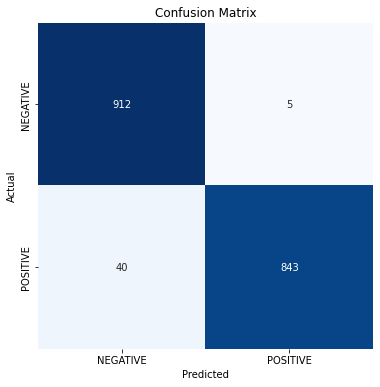

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.98       917
    POSITIVE       0.99      0.95      0.97       883

    accuracy                           0.97      1800
   macro avg       0.98      0.97      0.97      1800
weighted avg       0.98      0.97      0.97      1800



In [ ]:
evaluate_model(model, test_data)